In [ ]:
# Импорт необходимых библиотек для анализа и визуализации данных
import pandas as pd           # Работа с таблицами и обработка данных
import matplotlib.pyplot as plt  # Построение графиков
import seaborn as sns         # Улучшенная визуализация графиков
import numpy as np            # Работа с массивами и числовыми операциями

# Подключение Google Drive для загрузки данных
from google.colab import drive
drive.mount('/content/drive')

# Настройка отображения всех столбцов в выводе DataFrame
pd.set_option('display.max_columns', None)

# Функция для обзора структуры и содержимого датасета
def overview(df, name):
    """
    Выводит информацию о структуре, описательные статистики
    и первые строки данных для заданного DataFrame.

    Параметры:
        df (pd.DataFrame): Анализируемый датасет
        name (str): Имя датасета для заголовка
    """
    print(f"\n--- Обзор датасета: {name} ---")
    print(df.info())       # Общая информация о датасете
    print(df.describe())   # Статистическое описание числовых столбцов
    print(f"Примеры данных:\n{df.head()}\n")  # Первые строки таблицы

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Создание дополнительного датасет и функции для перевода из name в id и наоборот

In [ ]:
!pip install rapidfuzz

In [ ]:
# Загрузка и подготовка данных для работы с соответствиями между AppID и именами игр
import pandas as pd
from rapidfuzz import process  # Библиотека для нечёткого поиска строк

# Шаг 1: Загрузка исходного датасета с полным набором данных
df = pd.read_csv('/content/drive/My Drive/games_cleaned.csv')

# Создание нового датасета с двумя ключевыми столбцами: AppID и name
new_df = df[['AppID', 'name']]

# Сохранение нового датасета для дальнейшего использования
new_df.to_csv('/content/drive/My Drive/id-name.csv', index=False)

# Шаг 2: Загрузка подготовленного датасета для поиска
dataset = pd.read_csv('/content/drive/My Drive/id-name.csv')

# Приведение столбца с именами игр к нижнему регистру для унификации
dataset['name_normalized'] = dataset['name'].str.lower().str.strip()

# Функция для получения имени игры по её AppID
def get_name_by_appid(appid):
    """
    Находит имя игры по её уникальному идентификатору (AppID).

    Параметры:
        appid (int): Уникальный идентификатор игры.

    Возвращает:
        str: Имя игры или None, если идентификатор не найден.
    """
    row = dataset.loc[dataset['AppID'] == appid]
    if not row.empty:
        return row.iloc[0]['name']  # Возвращаем имя игры
    return None  # Возвращаем None, если игра не найдена

# Функция для получения AppID игры по её имени с использованием нечёткого поиска
def get_appid_by_name(name):
    """
    Находит AppID игры по её имени с использованием нечёткого поиска.

    Параметры:
        name (str): Имя игры.

    Возвращает:
        int: AppID игры или None, если игра не найдена.
    """
    name_normalized = name.lower().strip()  # Приводим имя к стандартному формату
    match = process.extractOne(name_normalized, dataset['name_normalized'])  # Ищем наиболее близкое совпадение
    if match and match[1] > 80:  # Проверяем, что точность совпадения выше порогового значения
        row = dataset.loc[dataset['name_normalized'] == match[0]]
        if not row.empty:
            return row.iloc[0]['AppID']  # Возвращаем AppID игры
    return None  # Возвращаем None, если совпадение не найдено

Этап 1. Исключение отсутствующих значений

In [ ]:
# Шаг 1: Загрузка датасета для анализа
games_cleaned = pd.read_csv('/content/drive/My Drive/games_may2024_full.csv')

# Шаг 2: Обзор структуры и содержимого загруженного датасета
overview(games_cleaned, 'games')

# Шаг 3: Проверка наличия пропущенных значений в столбцах
print("\nПропущенные значения в games.csv:")
print(games_cleaned.isnull().sum())


--- Обзор датасета: games ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87806 entries, 0 to 87805
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   AppID                     87806 non-null  int64  
 1   name                      87803 non-null  object 
 2   release_date              87806 non-null  object 
 3   required_age              87806 non-null  int64  
 4   price                     87806 non-null  float64
 5   dlc_count                 87806 non-null  int64  
 6   detailed_description      83656 non-null  object 
 7   about_the_game            83634 non-null  object 
 8   short_description         83713 non-null  object 
 9   reviews                   10314 non-null  object 
 10  header_image              87806 non-null  object 
 11  website                   39906 non-null  object 
 12  support_url               42224 non-null  object 
 13  support_email             7312

Удалить строки с пропущенными значениями или заменяем их:

In [ ]:
# Шаг 1: Удаление строк с отсутствующими значениями в поле 'name'
games_cleaned = games_cleaned.dropna(subset=['name']).copy()

# Шаг 2: Удаление дублирующихся значений в столбце 'name'
games_cleaned.drop_duplicates(subset=['name'], inplace=True)

# Шаг 3: Заполнение пропусков значениями по умолчанию для текстовых полей
games_cleaned['short_description'] = games_cleaned['short_description'].fillna("Description not available")
games_cleaned['about_the_game'] = games_cleaned['about_the_game'].fillna("Information not available")
games_cleaned['website'] = games_cleaned['website'].fillna("not")
games_cleaned['support_url'] = games_cleaned['support_url'].fillna("not")
games_cleaned['support_email'] = games_cleaned['support_email'].fillna("not")
games_cleaned['detailed_description'] = games_cleaned['detailed_description'].fillna("Detailed description not available")

# Шаг 4: Удаление нерелевантных столбцов
columns_to_drop = [
    'header_image', 'detailed_description', 'about_the_game', 'short_description',
    'reviews', 'notes', 'metacritic_url', 'estimated_owners',
    'num_reviews_recent', 'pct_pos_recent', 'tags', 'screenshots',
    'movies', 'packages', 'score_rank'
]
games_cleaned = games_cleaned.drop(columns=columns_to_drop)

# Шаг 5: Проверка данных после обработки
print("Пропуски в games_cleaned после финальной обработки:")
print(games_cleaned.isnull().sum())
overview(games_cleaned, 'games_cleaned')

# Шаг 6: Вывод итоговой размерности обработанного датасета
print("\nИтоговая размерность games_cleaned:", games_cleaned.shape)

Пропуски в games_cleaned после финальной обработки:
AppID                       0
name                        0
release_date                0
required_age                0
price                       0
dlc_count                   0
website                     0
support_url                 0
support_email               0
windows                     0
mac                         0
linux                       0
metacritic_score            0
achievements                0
recommendations             0
supported_languages         0
full_audio_languages        0
developers                  0
publishers                  0
categories                  0
genres                      0
user_score                  0
positive                    0
negative                    0
average_playtime_forever    0
average_playtime_2weeks     0
median_playtime_forever     0
median_playtime_2weeks      0
peak_ccu                    0
pct_pos_total               0
num_reviews_total           0
dtype: int64

--- 

In [ ]:
# Шаг 7: Сохранение обработанного датасета в файл
output_path = '/content/drive/My Drive/games_cleaned.csv'
games_cleaned.to_csv(output_path, index=False)

# Подтверждение успешного сохранения
print("Обработанный датасет успешно сохранён:")
print(f"- {output_path}")

Обработанный датасет успешно сохранён:
- /content/drive/My Drive/games_cleaned.csv


Этап 2. Приводим все фичи к числовому виду

In [ ]:
# Шаг 1: Загрузка обработанного датасета
df_selected = pd.read_csv("/content/drive/My Drive/games_cleaned.csv")

# Шаг 2: Первичная проверка данных
print("Первая информация о датасете:")
print(df_selected.head())  # Вывод первых строк для ознакомления
print("\nОписание структуры данных:")
print(df_selected.info())  # Вывод информации о типах данных и пропущенных значениях

Первая информация о датасете:
    AppID                             name release_date  required_age  price  \
0     730                 Counter-Strike 2   2012-08-21             0   0.00   
1  578080              PUBG: BATTLEGROUNDS   2017-12-21             0   0.00   
2     570                           Dota 2   2013-07-09             0   0.00   
3  271590               Grand Theft Auto V   2015-04-13            17   0.00   
4  488822  Tom Clancy's Rainbow Six® Siege   2015-12-01            17  19.99   

   dlc_count                          website  \
0          1       http://counter-strike.net/   
1          0             https://www.pubg.com   
2          2            http://www.dota2.com/   
3          1  http://www.rockstargames.com/V/   
4          9         http://rainbow6.ubi.com/   

                             support_url support_email  windows    mac  linux  \
0                                    not           not     True  False   True   
1  https://support.playbattlegro

In [ ]:
import ast

# Шаг 1: Функция для преобразования строк в списки
def convert_str_to_list(df, column):
    """
    Преобразует строковые представления списков в объекты типа list.

    Args:
        df (pd.DataFrame): Датасет для преобразования.
        column (str): Название столбца для обработки.

    Returns:
        pd.DataFrame: Обновленный датасет.
    """
    df[column] = df[column].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    return df

# Шаг 2: Преобразование строковых данных в списки для указанных столбцов
list_columns = ['supported_languages', 'full_audio_languages', 'developers', 'publishers']
for column in list_columns:
    df_selected = convert_str_to_list(df_selected, column)

# Шаг 3: Подсчёт уникальных значений в каждом из преобразованных столбцов
for column in list_columns:
    unique_values = df_selected[column].apply(lambda x: len(set(x)) if isinstance(x, list) else 0)
    print(f"\nУникальные значения в столбце '{column}': {unique_values.sum()}")
    print(f"Примеры уникальных значений в '{column}':")
    print(unique_values.head())


Уникальные значения в столбце 'supported_languages': 395150
Примеры уникальных значений в 'supported_languages':
0    28
1    17
2    28
3    13
4    16
Name: supported_languages, dtype: int64

Уникальные значения в столбце 'full_audio_languages': 165018
Примеры уникальных значений в 'full_audio_languages':
0    2
1    0
2    4
3    2
4    9
Name: full_audio_languages, dtype: int64

Уникальные значения в столбце 'developers': 90623
Примеры уникальных значений в 'developers':
0    1
1    1
2    1
3    1
4    1
Name: developers, dtype: int64

Уникальные значения в столбце 'publishers': 90168
Примеры уникальных значений в 'publishers':
0    1
1    1
2    1
3    1
4    1
Name: publishers, dtype: int64


In [ ]:
from collections import Counter

# Шаг 1: Функция для подсчёта частоты значений
def count_encode(column):
    """
    Преобразует списки в строковые представления, подсчитывает частоту их появления и заменяет на частотное значение.

    Args:
        column (pd.Series): Столбец с данными, содержащий списки или строки.

    Returns:
        pd.Series: Обновлённый столбец с частотными значениями.
    """
    # Преобразуем списки в строку, разделённую запятыми
    column_as_str = column.apply(lambda x: ','.join(x) if isinstance(x, list) else str(x))
    # Подсчитываем частоту каждого уникального значения
    counts = Counter(column_as_str)
    # Заменяем значения на их частотные представления
    return column_as_str.map(counts)

# Шаг 2: Применение кодировки к указанным столбцам
columns_to_encode = ['supported_languages', 'full_audio_languages', 'developers', 'publishers']
for column in columns_to_encode:
    df_selected[column] = count_encode(df_selected[column])

from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

# Шаг 3: Функция для вычисления разницы между текущей датой и датой релиза
def del_data(date_str):
    """
    Преобразует дату релиза игры в количество дней, прошедших с этой даты до 2024 года.

    Args:
        date_str (str): Дата в формате 'YYYY-MM-DD'.

    Returns:
        int: Количество дней.
    """
    return (2024 - int(date_str[:4])) * 365 + (12 - int(date_str[5:7])) * 30 + int(date_str[8:10])

# Шаг 4: Обработка столбцов с датами и ссылками
df_processed = df_selected.copy()
df_processed['release_date'] = df_processed['release_date'].apply(del_data)

# Преобразование наличия информации о веб-сайте, поддержке в бинарные признаки
for column in ['website', 'support_url', 'support_email']:
    df_processed[column] = np.where(df_processed[column] == 'not', 0, 1)

# Шаг 5: Обработка столбца 'genres' (жанры)
# Убираем лишние символы из строк и разделяем жанры
df_processed['genres'] = df_processed['genres'].str.replace(r"[\[\]']", '', regex=True)
genres_dummies = df_processed['genres'].str.get_dummies(sep=', ')

# Объединяем закодированные жанры с основным датафреймом и удаляем оригинальный столбец
df_processed = pd.concat([df_processed, genres_dummies], axis=1)
df_processed.drop(columns=['genres', 'name'], inplace=True)

# Шаг 6: Обработка столбца 'categories' (категории)
# Убираем лишние символы и преобразуем строки в списки
df_processed['categories'] = df_processed['categories'].str.replace(r"[\[\]']", '', regex=True)
df_processed['categories'] = df_processed['categories'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

# Бинарное кодирование категорий с использованием MultiLabelBinarizer
mlb = MultiLabelBinarizer()
categories_encoded = mlb.fit_transform(df_processed['categories'])

# Создание датафрейма с закодированными категориями
categories_df = pd.DataFrame(categories_encoded, columns=mlb.classes_)

# Добавляем бинарные категории в основной датафрейм и удаляем оригинальный столбец
df_processed = pd.concat([df_processed, categories_df], axis=1)
df_processed.drop(columns=['categories'], inplace=True)

# Шаг 7: Просмотр результата обработки
print("Данные после обработки жанров и категорий:")
print(df_processed.head())
print("\nОписание данных:")
print(df_processed.info())

Данные после обработки жанров и категорий:
    AppID  release_date  required_age  price  dlc_count  website  support_url  \
0     730          4521             0   0.00          1        1            0   
1  578080          2576             0   0.00          0        1            1   
2     570          4174             0   0.00          2        1            0   
3  271590          3538            17   0.00          1        1            1   
4  488822          3286            17  19.99          9        1            1   

   support_email  windows    mac  linux  metacritic_score  achievements  \
0              0     True  False   True                 0             1   
1              0     True  False  False                 0            37   
2              0     True   True   True                90             0   
3              0     True  False  False                96            77   
4              0     True  False  False                 0             0   

   recommendations 

In [ ]:
# Шаг 6: Сохранение обработанного датасета
output_path = '/content/drive/My Drive/df_processed.csv'
df_processed.to_csv(output_path, index=False)

# Уведомление о завершении сохранения
print("Обработанные датасеты успешно сохранены:")
print(f"- {output_path}")

Обработанные датасеты успешно сохранены:
- df_processed.csv


Этап 3. Избавляемся от сильно коррелирующих признаков

In [ ]:
# Этап 3. Шаг 1: Загрузка данных и первичный анализ
input_path = "/content/drive/My Drive/df_processed.csv"
df_processed = pd.read_csv(input_path)

# Вывод первых строк для проверки структуры данных
print("Первая информация о датасете:")
print(df_processed.head())

# Вывод описания данных (типы данных, пропуски, объем памяти)
print("\nОписание данных:")
print(df_processed.info())

Первая информация о датасете:
    AppID  release_date  required_age  price  dlc_count  website  support_url  \
0     730          4521             0   0.00          1        1            0   
1  578080          2576             0   0.00          0        1            1   
2     570          4174             0   0.00          2        1            0   
3  271590          3538            17   0.00          1        1            1   
4  488822          3286            17  19.99          9        1            1   

   support_email  windows    mac  linux  metacritic_score  achievements  \
0              0     True  False   True                 0             1   
1              0     True  False  False                 0            37   
2              0     True   True   True                90             0   
3              0     True  False  False                96            77   
4              0     True  False  False                 0             0   

   recommendations  supported_la

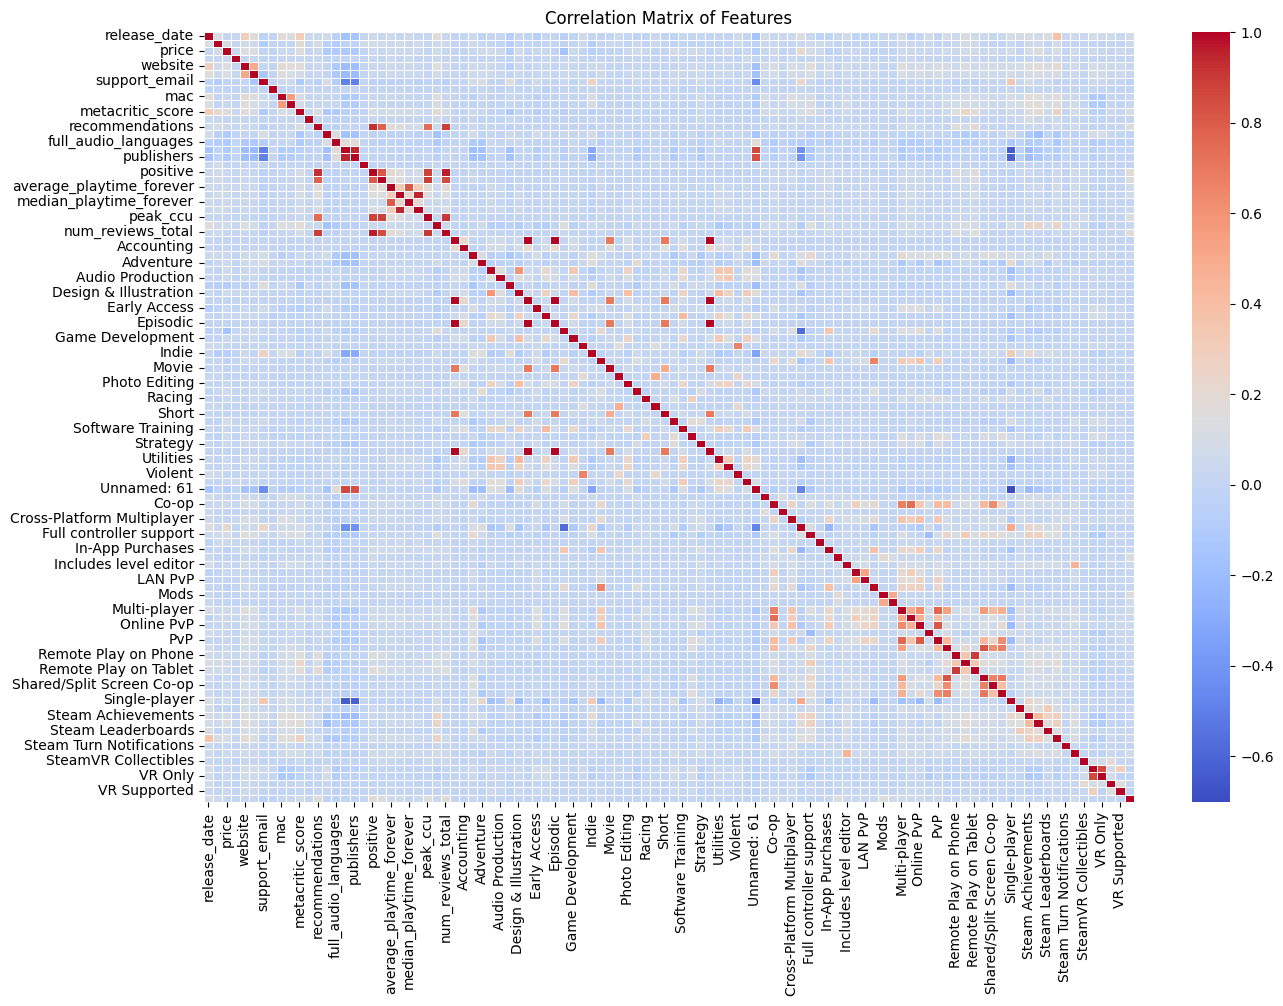

In [ ]:
# Этап 3. Шаг 2: Отбор числовых столбцов и визуализация корреляции

# Выбираем только числовые столбцы (float, int, bool)
numerical_columns = df_processed.select_dtypes(include=['float64', 'int64', 'bool']).columns

# Исключаем первый столбец (если это, например, индекс или идентификатор)
numerical_columns = numerical_columns[1:]  # Убираем первый столбец

# Рассчитываем корреляционную матрицу
correlation_matrix = df_processed[numerical_columns].corr()

# Визуализация корреляционной матрицы с помощью тепловой карты
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()


Удаляем фичи без корреляции: ['user_score']
Количество признаков после обработки: 73
Новый DataFrame:
   release_date  required_age  price  dlc_count  website  support_email  \
0          4521             0   0.00          1        1              0   
1          2576             0   0.00          0        1              0   
2          4174             0   0.00          2        1              0   
3          3538            17   0.00          1        1              0   
4          3286            17  19.99          9        1              0   

   windows    mac  metacritic_score  achievements  recommendations  \
0     True  False                 0             1          4111974   
1     True  False                 0            37          1701431   
2     True   True                90             0            14329   
3     True  False                96            77          1641404   
4     True  False                 0             0          1090810   

   supported_languages  fu

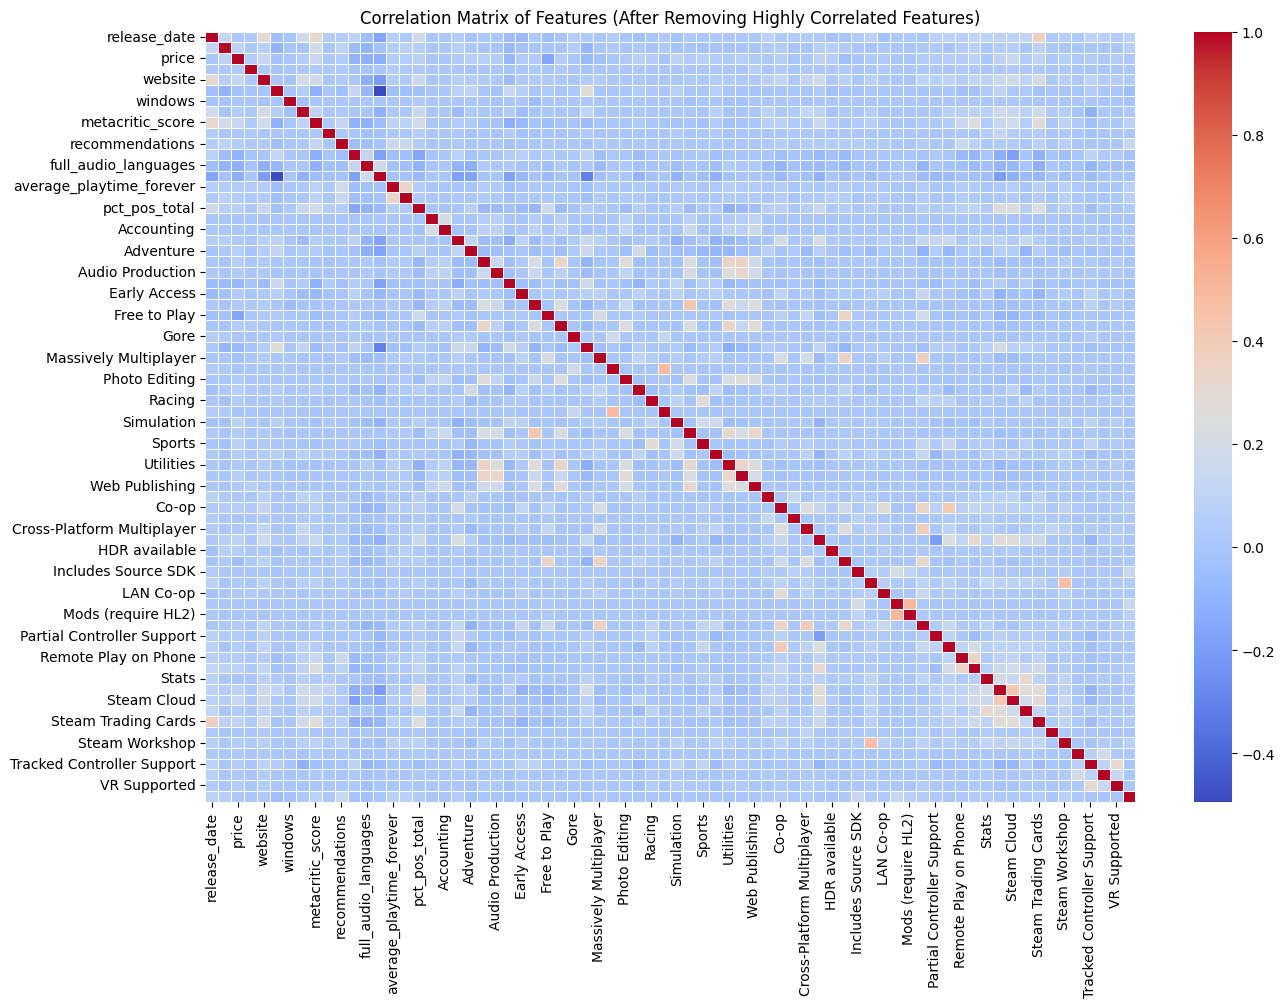

In [ ]:
# Этап 3. Шаг 3: Удаление признаков с высокой корреляцией

# Устанавливаем порог для корреляции
threshold = 0.5

# Создаем копию датафрейма для дальнейшей работы, исключаем 'AppID'
df_reduced = df_processed.copy()
df_reduced.drop(columns=['AppID'], inplace=True)

# Находим и удаляем признаки с низкой корреляцией (если сумма абсолютных корреляций по столбцу < порог)
uncorrelated_features = correlation_matrix.columns[(correlation_matrix.abs().sum(axis=0) - 1) <= 0.5]
if not uncorrelated_features.empty:
    print(f"Удаляем фичи без корреляции: {list(uncorrelated_features)}")
    df_reduced.drop(columns=uncorrelated_features, inplace=True)

# Пересчитываем корреляционную матрицу после удаления некоррелирующих признаков
correlation_matrix = df_reduced.corr()

# Пока есть корреляции выше заданного порога, удаляем признаки
while True:
    # Ищем пары признаков с корреляцией, превышающей порог
    high_corr = np.where(np.abs(correlation_matrix) > threshold)
    high_corr_pairs = [(correlation_matrix.index[i], correlation_matrix.columns[j])
                       for i, j in zip(*high_corr) if i != j]

    # Если нет высококоррелирующих признаков, выходим из цикла
    if not high_corr_pairs:
        break

    # Выбираем первую пару с высокой корреляцией
    feature1, feature2 = high_corr_pairs[0]

    # Удаляем один из признаков в паре (например, второй)
    if feature2 in df_reduced.columns:
        df_reduced.drop(columns=[feature2], inplace=True)

    # Пересчитываем корреляционную матрицу после удаления признака
    correlation_matrix = df_reduced.corr()

# Восстановим 'AppID' обратно в датафрейм
df_reduced = pd.concat([df_reduced, df_processed['AppID']], axis=1)

# Выводим информацию о результатах
print("Количество признаков после обработки:", df_reduced.shape[1])
print("Новый DataFrame:")
print(df_reduced.head())

# Визуализация новой корреляционной матрицы
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Features (After Removing Highly Correlated Features)")
plt.show()


In [ ]:
# Сохраняем обновленный датасет в новый файл
df_reduced.to_csv('/content/drive/My Drive/games_cleaned_filtered.csv', index=False)

print("Обновленный датасет сохранен в 'games_cleaned_filtered.csv'")

Обновленный датасет сохранен в 'games_cleaned_filtered.csv'


Этап 4. Уменьшения размерности.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Загрузка данных
file_path = '/content/drive/My Drive/games_cleaned_filtered.csv'
df = pd.read_csv(file_path)

# Удаляем 'AppID', так как он не участвует в анализе
data_for_reduction = df_reduced.drop(columns=['AppID']).values

# Масштабирование данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_reduction)

# Уменьшение размерности с помощью PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Объясненная дисперсия
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

# Находим минимальное количество компонент, объясняющих 95% дисперсии
threshold = 0.95
num_components = next(i for i, total in enumerate(cumulative_variance) if total >= threshold) + 1

print(f"Общая объяснённая дисперсия (суммарно): {cumulative_variance[-1]:.4f}")
print(f"Количество компонент для объяснения {threshold*100}% дисперсии: {num_components}")

# Применяем PCA с найденным числом компонент
pca = PCA(n_components=num_components)
reduced_data = pca.fit_transform(scaled_data)

# Сохраняем результат уменьшения размерности
reduced_df = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(num_components)])
reduced_df['AppID'] = df_reduced['AppID'].values

print("Этап уменьшения размерности завершён.")

NameError: name 'df_reduced' is not defined

In [ ]:
# Просмотр первых строк и структуры данных
print("Первая информация о датасете:")
print(reduced_df.head())
print("\nОписание данных:")
print(reduced_df.info())


Первая информация о датасете:
         PC1        PC2       PC3        PC4        PC5        PC6        PC7  \
0  29.714019  19.114113  9.168103 -42.312106  18.248323 -14.911071  20.636571   
1   9.990397   5.674709  5.456251 -15.366302   6.255266  -1.113708   6.180242   
2  11.403957   8.804952  6.550281 -13.840444   8.123341 -11.908038  11.622488   
3  16.026992   8.948646  1.134296 -20.649350   8.197499   0.827252  10.092538   
4   9.985815   5.231429  3.690925 -13.463840   5.034069   1.700418   5.708536   

         PC8        PC9       PC10       PC11       PC12       PC13  \
0  13.172287 -30.340745 -42.810210 -22.101196  88.724635 -18.560808   
1   4.214289  -9.050687 -12.571977  -6.141612  30.257452  -6.479154   
2   0.771386 -12.124203  -7.307416 -10.799716  20.536758 -15.468148   
3   4.006930 -14.004143 -18.313083  -6.708622  37.372873  -6.733147   
4   2.389744  -6.607529  -8.064955  -2.534731  19.927350  -2.821644   

        PC14       PC15       PC16       PC17       PC18

In [ ]:
# Сохраняем обновленный датасет в новый файл
reduced_df.to_csv('/content/drive/My Drive/games_ym_raz.csv', index=False)

print("Обновленный датасет сохранен в 'games_ym_raz.csv'")

Обновленный датасет сохранен в 'games_cleaned_filtered.csv'


In [ ]:
Этап 5.(ИСКЛЮЧЕННЫЙ) Кластеризация + этап удаление выбросов

In [ ]:
# Загрузка данных
file_path = '/content/drive/My Drive/games_ym_raz.csv'
df = pd.read_csv(file_path)

# Удаляем 'AppID', так как он не участвует в анализе
df = df.drop(columns=['AppID'])

удаление выбросов

In [ ]:
# Изначальное количество записей
initial_count = len(df)

# Функция для удаления выбросов с мягким порогом
def remove_outliers_soft(df, factor=3):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    # Используем мягкий порог для удаления выбросов
    return df[~((df < (Q1 - factor * IQR)) | (df > (Q3 + factor * IQR))).any(axis=1)]

# Удаление выбросов с мягким порогом
df_cleaned = remove_outliers_soft(df)

# Итоговое количество записей
final_count = len(df_cleaned)

# Процентное изменение
removed_percentage = ((initial_count - final_count) / initial_count) * 100

# Результаты
print(f"Изначальное количество записей: {initial_count}")
print(f"Итоговое количество записей: {final_count}")
print(f"Процент удаленных выбросов: {removed_percentage:.2f}%")


Изначальное количество записей: 87115
Итоговое количество записей: 66817
Процент удаленных выбросов: 23.30%


DBSCAN

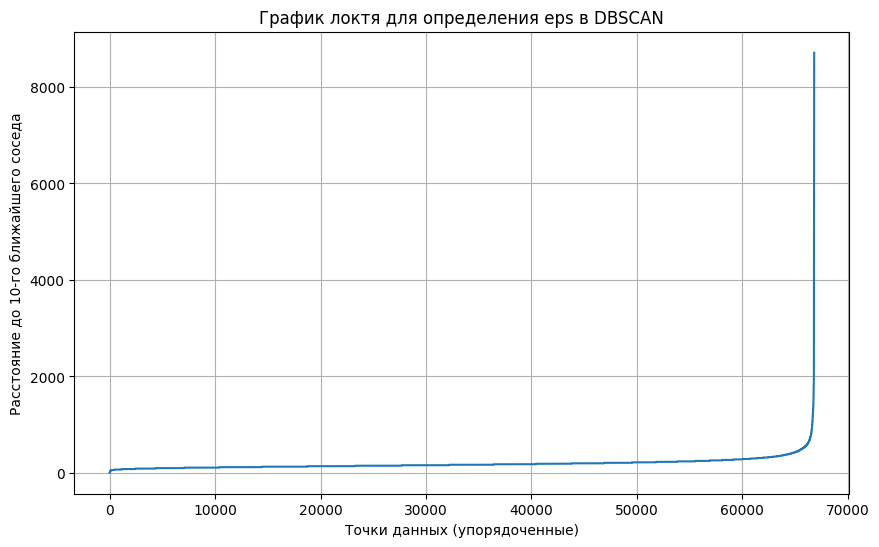

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Определяем количество соседей для анализа
k = 10

# Рассчитываем расстояния до ближайших соседей
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df_cleaned)
distances, indices = neighbors_fit.kneighbors(df_cleaned)

# Сортируем расстояния для построения графика локтя
distances = np.sort(distances[:, k-1])  # Берём расстояние до k-го соседа

# Строим график локтя
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title("График локтя для определения eps в DBSCAN")
plt.xlabel("Точки данных (упорядоченные)")
plt.ylabel(f"Расстояние до {k}-го ближайшего соседа")
plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# Параметры DBSCAN (значения eps и min_samples подберите по графику локтя)
eps = 0.5  # примерное значение, заменить на оптимальное
min_samples = 5

# Выполняем кластеризацию DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(df_cleaned)

# Сокращаем размерность данных до 2D для визуализации с помощью PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_cleaned)

# Визуализация результатов
plt.figure(figsize=(10, 6))
unique_labels = set(labels)
colors = [plt.cm.tab10(i / len(unique_labels)) for i in range(len(unique_labels))]

for label, color in zip(unique_labels, colors):
    if label == -1:  # Выделяем шум отдельным цветом (кластер -1)
        color = 'black'
        label_name = "Шум"
    else:
        label_name = f"Кластер {label}"

    plt.scatter(reduced_data[labels == label, 0],
                reduced_data[labels == label, 1],
                c=[color], label=label_name, s=20)

plt.title("Результаты кластеризации DBSCAN")
plt.xlabel("Главный компонент 1")
plt.ylabel("Главный компонент 2")
plt.legend()
plt.grid()
plt.show()

K-means

0.5 %
1.0 %
1.5 %
2.0 %
2.5 %
3.0 %
3.5 %
4.0 %
4.5 %
5.0 %
5.5 %
6.0 %
6.5 %
7.0 %
7.5 %
8.0 %
8.5 %
9.0 %
9.5 %
10.0 %
10.5 %
11.0 %
11.5 %
12.0 %
12.5 %
13.0 %
13.5 %
14.0 %
14.5 %
15.0 %
15.5 %
16.0 %
16.5 %
17.0 %
17.5 %
18.0 %
18.5 %
19.0 %
19.5 %
20.0 %
20.5 %
21.0 %
21.5 %
22.0 %
22.5 %
23.0 %
23.5 %
24.0 %
24.5 %
25.0 %
25.5 %
26.0 %
26.5 %
27.0 %
27.5 %
28.0 %
28.5 %
29.0 %
29.5 %
30.0 %
30.5 %
31.0 %
31.5 %
32.0 %
32.5 %
33.0 %
33.5 %
34.0 %
34.5 %
35.0 %
35.5 %
36.0 %
36.5 %
37.0 %
37.5 %
38.0 %
38.5 %
39.0 %
39.5 %
40.0 %
40.5 %
41.0 %
41.5 %
42.0 %
42.5 %
43.0 %
43.5 %
44.0 %
44.5 %
45.0 %
45.5 %
46.0 %
46.5 %
47.0 %
47.5 %
48.0 %
48.5 %
49.0 %
49.5 %
50.0 %
50.5 %
51.0 %
51.5 %
52.0 %
52.5 %
53.0 %
53.5 %
54.0 %
54.5 %
55.0 %
55.5 %
56.0 %
56.5 %
57.0 %
57.5 %
58.0 %
58.5 %
59.0 %
59.5 %
60.0 %
60.5 %
61.0 %
61.5 %
62.0 %
62.5 %
63.0 %
63.5 %
64.0 %
64.5 %
65.0 %
65.5 %
66.0 %
66.5 %
67.0 %
67.5 %
68.0 %
68.5 %
69.0 %
69.5 %
70.0 %
70.5 %
71.0 %
71.5 %
72.0 %
72.5 %
73.0

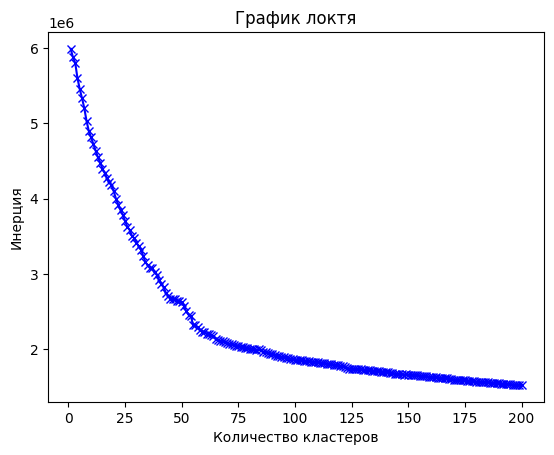

In [ ]:
from sklearn.cluster import KMeans
# вычислить данные графика локтя
inertias = []
abc=0
for k in range(1, 201):
    abc=abc+1
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
    inertias.append(kmeans.inertia_)
    print(abc/2,'%')

# построить график локтя
plt.plot(range(1, 201), inertias, 'bx-')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.title('График локтя')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
for i in range(44,55,2):
  print('при ',i,' кластерах')
  # применить кластеризацию с оптимальным количеством кластеров (определенным из графика локтя)
  n_clusters =i # значение оптимального количества кластеров
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df_cleaned)

  # вывести метрики кластеризации
  print('Силуэтный коэффициент:', silhouette_score(df_cleaned, kmeans.labels_))
  print('Индекс Калинского-Харабаса:', calinski_harabasz_score(df_cleaned, kmeans.labels_))
  print('Индекс Дэвиса-Болдина:', davies_bouldin_score(df_cleaned, kmeans.labels_))

  # вывести количество значений в каждом кластере
  for i in range(n_clusters):
      print(f'Количество значений в кластере {i}: {len(df_cleaned[kmeans.labels_ == i])}')

при  44  кластерах
Силуэтный коэффициент: 0.09694739352129818
Индекс Калинского-Харабаса: 2442.1420762348775
Индекс Дэвиса-Болдина: 1.5186758629113917
Количество значений в кластере 0: 99
Количество значений в кластере 1: 9392
Количество значений в кластере 2: 1
Количество значений в кластере 3: 1
Количество значений в кластере 4: 636
Количество значений в кластере 5: 5535
Количество значений в кластере 6: 38
Количество значений в кластере 7: 367
Количество значений в кластере 8: 2682
Количество значений в кластере 9: 6575
Количество значений в кластере 10: 1054
Количество значений в кластере 11: 11579
Количество значений в кластере 12: 1740
Количество значений в кластере 13: 763
Количество значений в кластере 14: 187
Количество значений в кластере 15: 241
Количество значений в кластере 16: 1164
Количество значений в кластере 17: 88
Количество значений в кластере 18: 887
Количество значений в кластере 19: 4692
Количество значений в кластере 20: 88
Количество значений в кластере 21: 328

Иерархическая кластеризация

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Выполнение иерархической кластеризации
# 'ward' - метод минимизации дисперсии, подходит для большинства данных
linkage_matrix = linkage(df_cleaned, method='ward')

# Задание количества кластеров
n_clusters = 4  # Укажите предполагаемое количество кластеров
labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

# Оценка качества кластеризации
silhouette_avg = silhouette_score(df_cleaned, labels)
calinski_harabasz = calinski_harabasz_score(df_cleaned, labels)
davies_bouldin = davies_bouldin_score(df_cleaned, labels)

print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")

# Построение дендрограммы
#plt.figure(figsize=(12, 8))
#dendrogram(linkage_matrix, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=12.)
#plt.title("Дендрограмма")
#plt.xlabel("Индекс наблюдения или кластера")
#plt.ylabel("Евклидово расстояние")
#plt.show()

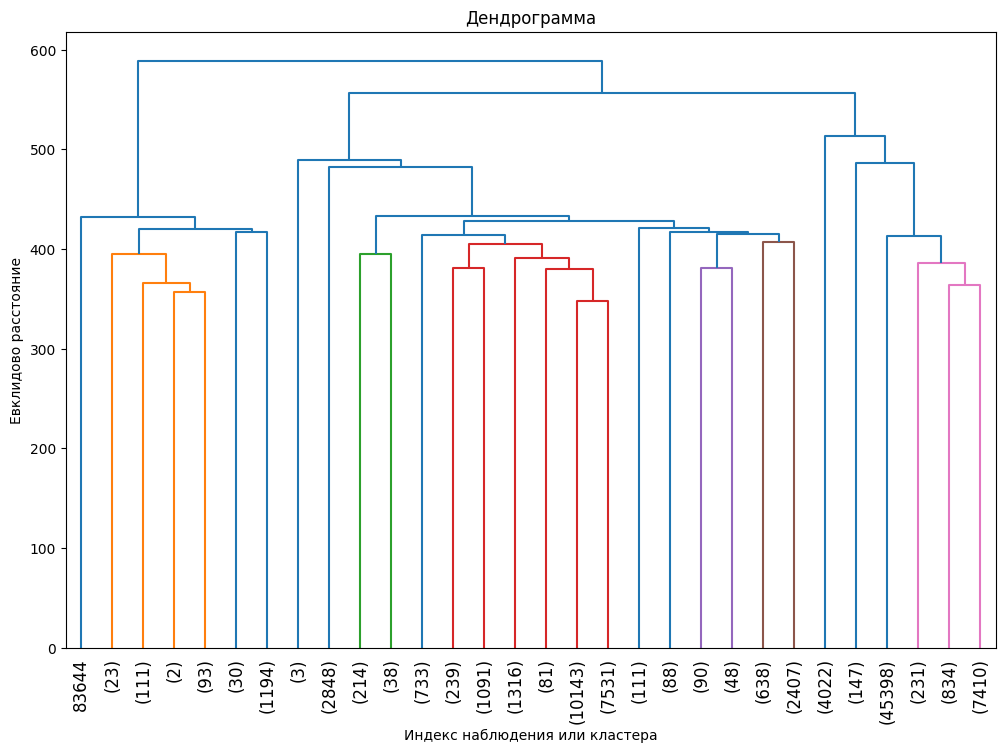

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Выполнение иерархической кластеризации
# 'ward' - метод минимизации дисперсии, подходит для большинства данных
linkage_matrix = linkage(df_cleaned, method='ward')

# Построение дендрограммы
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=12.)
plt.title("Дендрограмма")
plt.xlabel("Индекс наблюдения или кластера")
plt.ylabel("Евклидово расстояние")
plt.show()

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
# Задание количества кластеров
n_clusters = 4  # Укажите предполагаемое количество кластеров
labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

# Оценка качества кластеризации
silhouette_avg = silhouette_score(df_cleaned, labels)
calinski_harabasz = calinski_harabasz_score(df_cleaned, labels)
davies_bouldin = davies_bouldin_score(df_cleaned, labels)

print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")

NameError: name 'linkage_matrix' is not defined

Этап построение модели

In [ ]:
# Загрузка данных
file_path = '/content/drive/My Drive/games_ym_raz.csv'
games = pd.read_csv(file_path)

In [ ]:
features = games.drop(columns=['AppID'])  # 'AppID' — целевая переменная
target = games['AppID']

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Создаем модель Nearest Neighbors
knn_model = NearestNeighbors(n_neighbors=6, metric='euclidean')
knn_model.fit(features)

# Функция для рекомендации
def recommend_games_v1(game_id, data, model, n_recommendations=10):
    # Получаем фичи игры по ID
    game_features = data[data['AppID'] == game_id].drop(columns=['AppID'])
    if game_features.empty:
        return f"Игра с ID {game_id} не найдена!"

    # Находим соседей
    distances, indices = model.kneighbors(game_features, n_neighbors=n_recommendations+1)

    # Возвращаем рекомендованные ID игр
    recommended_ids = data.iloc[indices[0]]['AppID'].values[1:]  # Пропускаем саму игру
    return recommended_ids

In [ ]:
import joblib

# Сохранение модели в файл
joblib.dump(knn_model, 'nearest_neighbors_model.pkl')

['nearest_neighbors_model.pkl']

In [ ]:
# Тестируем на примере
game_id_to_recommend = 730  # Введите ID игры для теста
recommendations = recommend_games_v1(game_id_to_recommend, games, knn_model)
print(f"Рекомендованные игры для ID {game_id_to_recommend}: {recommendations}")

Рекомендованные игры для ID 730: [ 578080  271590  488822  105600  252490    4000  292030  431960 1091500
  553850]


In [ ]:
# Запрашиваем название игры у пользователя
title = input("Название игры: ")

# Получаем AppID игры по введенному названию
game_id_to_recommend = get_appid_by_name(title)

# Получаем рекомендации для найденной игры
recommendations = recommend_games_v1(game_id_to_recommend, games, knn_model)

# Выводим заголовок с названием игры, для которой делаются рекомендации
print(f"Рекомендованные игры для {get_name_by_appid(game_id_to_recommend)}:")

# Инициализируем счетчик для вывода списка рекомендованных игр
p = 0
# Для каждой рекомендованной игры выводим её номер и название
for i in recommendations:
    p = p + 1
    print(p, ') ', get_name_by_appid(i))

Название игры: heroes of might and magic 3
Рекомендованные игры для Hero:
1 )  Space Survival
2 )  Lex Mortis
3 )  Overcast - Walden and the Werewolf
4 )  Wooden House
5 )  Red Forest
6 )  Spaceport Hope
7 )  Nano Project
8 )  A Demon's Game - Episode 1
9 )  The Sheltered
10 )  Lost in a Forest


In [ ]:
# Загрузка данных
file_path = '/content/drive/My Drive/games_ym_raz.csv'
df = pd.read_csv(file_path)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# Подготовка данных
# df - ваш DataFrame с характеристиками игр
# 'id' - столбец с ID игры
# Остальные 65 столбцов - фичи игры
game_ids = df['AppID']
features = df.drop(columns=['AppID'])

# Вычисление сходства (например, косинусное сходство)
similarity_matrix = cosine_similarity(features)

# Функция для получения рекомендаций
def recommend_games_v2(game_id, similarity_matrix, game_ids, top_n=10):
    # Находим индекс игры по ID
    game_index = game_ids[game_ids == game_id].index[0]

    # Сходства данной игры со всеми остальными
    similarities = similarity_matrix[game_index]

    # Сортировка по убыванию сходства
    similar_games = np.argsort(similarities)[::-1]

    # Исключаем саму игру из рекомендаций
    similar_games = [i for i in similar_games if i != game_index]

    # Получаем топ-N похожих игр
    recommended_ids = game_ids.iloc[similar_games[:top_n]].values
    return recommended_ids

In [ ]:

# Пример использования
game_id = 730  # Замените на существующий ID игры
top_10_recommendations = recommend_games_v2(game_id, similarity_matrix, game_ids, top_n=10)

print(f"Рекомендации для игры с ID {game_id}: {top_10_recommendations}")


In [ ]:
title="Valheim"
game_id_to_recommend = get_appid_by_name(title)
recommendations = recommend_games_v2(game_id, similarity_matrix, game_ids, top_n=10)
print(f"Рекомендованные игры для {get_name_by_appid(game_id_to_recommend)}:")
p=0
for i in recommendations:
  p=p+1
  print(p,') ',get_name_by_appid(i))

In [ ]:
import customtkinter as ctk
import tkinter as tk
import pandas as pd
from rapidfuzz import process

# Загрузка датасета один раз
dataset = pd.read_csv('id-name.csv')

# Приведение к единому формату
dataset['name_normalized'] = dataset['name'].str.lower().str.strip()

def get_name_by_appid(appid):
    """Получение имени игры по AppID"""
    row = dataset.loc[dataset['AppID'] == appid]
    if not row.empty:
        return row.iloc[0]['name']
    return None

def get_appid_by_name(name):
    """Получение AppID игры по имени (с нечётким поиском)"""
    name_normalized = name.lower().strip()
    match = process.extractOne(name_normalized, dataset['name_normalized'])
    if match and match[1] > 80:  # Порог точности (например, 80%)
        row = dataset.loc[dataset['name_normalized'] == match[0]]
        if not row.empty:
            return row.iloc[0]['AppID']
    return None

# Загрузка данных
file_path = 'games_ym_raz.csv'
games = pd.read_csv(file_path)
# Загрузка модели
import joblib
knn_model = joblib.load('nearest_neighbors_model.pkl')
game_ids = games['AppID']
features = games.drop(columns=['AppID'])
# Функция для рекомендации
def recommend_games_v1(game_id, data, model, n_recommendations=10):
    # Получаем фичи игры по ID
    game_features = data[data['AppID'] == game_id].drop(columns=['AppID'])
    if game_features.empty:
        return f"Игра с ID {game_id} не найдена!"

    # Находим соседей
    distances, indices = model.kneighbors(game_features, n_neighbors=n_recommendations+1)

    # Возвращаем рекомендованные ID игр
    recommended_ids = data.iloc[indices[0]]['AppID'].values[1:]  # Пропускаем саму игру
    return recommended_ids

# Настройка темы и начальных параметров CustomTkinter
ctk.set_appearance_mode("dark")  # Вариант оформления: "light", "dark", "system"
ctk.set_default_color_theme("blue")  # Цветовая тема: "blue", "dark-blue", "green"

# Создаем главное окно
root = ctk.CTk()
root.title("Рекомендация игр")
root.geometry("550x380")
root.resizable(False, False)

# Функция обработки введенной строки
def process_input():
    user_input = input_entry.get()  # Получаем текст из поля ввода
    if user_input.strip():  # Проверяем, что строка не пустая
        # Обрабатываем строку (переворачиваем)
        game_id_to_recommend = get_appid_by_name(user_input)
        recommendations = recommend_games_v1(game_id_to_recommend, games, knn_model)
        results=[]
        for i in recommendations:
            results=results+[get_name_by_appid(i)]
        # Очищаем поле ввода
        input_entry.delete(0, tk.END)

        # Выводим обработанную строку и обновляем список
        processed_label.configure(text=f"Обработанная строка: {get_name_by_appid(game_id_to_recommend)}")
        results_text.configure(state="normal")  # Разрешаем запись
        results_text.delete(1.0, "end")  # Очищаем текстовое поле
        results_text.insert("end", "\n".join(results))  # Выводим список
        results_text.configure(state="disabled")  # Запрещаем редактирование

# Создаем элементы интерфейса
input_label = ctk.CTkLabel(root, text="Введите игру:", font=("Comic Sans MS", 14))
input_label.grid(row=0, column=0, padx=10, pady=15, sticky="w")

input_entry = ctk.CTkEntry(root, placeholder_text="Введите название игры", width=250)
input_entry.grid(row=0, column=1, padx=10, pady=15, sticky="w")

process_button = ctk.CTkButton(root, text="Найти!", command=process_input, width=100)
process_button.grid(row=0, column=2, padx=10, pady=15, sticky="w")

processed_label = ctk.CTkLabel(root, text="Рекомендованные игры:", font=("Comic Sans MS", 14))
processed_label.grid(row=1, column=0, columnspan=3, padx=10, pady=10, sticky="w")

results_label = ctk.CTkLabel(root, text="Топ 10 игр:", font=("Comic Sans MS", 14))
results_label.grid(row=2, column=0, columnspan=3, padx=10, pady=10, sticky="w")

results_text = ctk.CTkTextbox(root, width=500, height=190, state="disabled", font=("Comic Sans MS", 12))
results_text.grid(row=3, column=0, columnspan=3, padx=10, pady=15)

# Запуск главного цикла приложения
root.mainloop()